# Generate a PV diagram using PVExtractor

In [1]:
import pylab as plt
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord

# set so that these display properly on black backgrounds
plt.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube
import aplpy

from pvextractor import extract_pv_slice, Path, PathFromCenter

### First use the scattered light image to get the vector along which we'll generate the PV diagram

In [2]:
# load in the PS1 g-band image which we need to identify the disk's midplane

gband_file = '/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits'
gband = fits.open(gband_file)

wcs_gband = WCS(gband[0].header)
gband_data = gband[0].data
gband_header = gband[0].header

#gband_header

In [3]:
# then load in the 12CO data cube which is needed to obtain the velocities

spectral_cube = SpectralCube.read('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/DraChi.briggs0.12CO.LSRK.im.image_modified_header.fits')

spectral_cube = spectral_cube.with_spectral_unit(unit=u.km/u.s, rest_value=230.538*u.GHz, velocity_convention='radio')
spectral_cube._unit = u.Jy/u.beam

spectral_cube

VaryingResolutionSpectralCube with shape=(60, 144, 144) and unit=Jy / beam:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   347.406190 deg:  347.457880 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    67.384148 deg:   67.404009 deg
 n_s:     60  type_s: VRAD      unit_s: km / s  range:      -16.227 km / s:       5.202 km / s

In [4]:
# define the centtral point of the vector (I got the coordinates from CASA)
ra_cen = 347.4323*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=152*u.deg, sample=2, width=1.*u.arcsec)

pvdiagram = extract_pv_slice(cube=spectral_cube, path=Path, spacing=1.)

(23.0, 50.0)

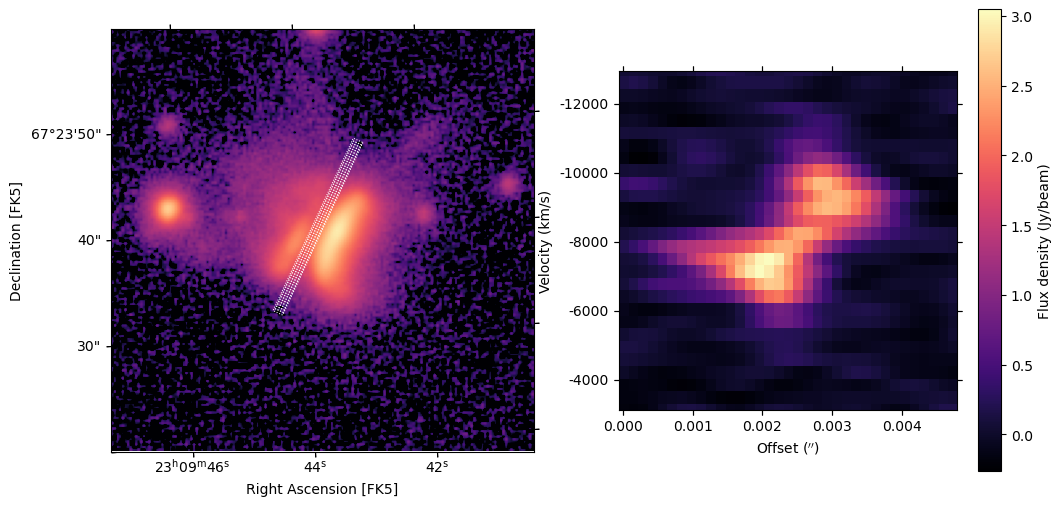

In [5]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_gband)

ax.imshow(gband_data, cmap='magma', norm=SymLogNorm(linthresh=1e1, linscale=0.001, vmin=-10, vmax=1e5))
Path.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)



# then show the PV diagram
ww = wcs.WCS(pvdiagram.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww)
im = ax.imshow(pvdiagram.data, cmap='magma')


#ax0 = ax.coords[0]
#ax0.set_format_unit(u.arcsec)
#ax1 = ax.coords[1]
#ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)
cb.set_label("Flux density (Jy/beam)")

ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)


ax.set_ylim(23, 50)




## Repeat the same analysis but now compute the PV diagram along the 12CO channel map

In [6]:
# load in the PS1 g-band image which we need to identify the disk's midplane

mom0_file = '/Users/kristina/Hamburgers/Draculas_Chivito/SMA/DraChi.briggs0.12CO.LSRK.im.image_M0.fits'
mom0 = fits.open(mom0_file)

wcs_mom0 = WCS(mom0[0].header)
mom0_data = mom0[0].data
mom0_header = mom0[0].header



/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


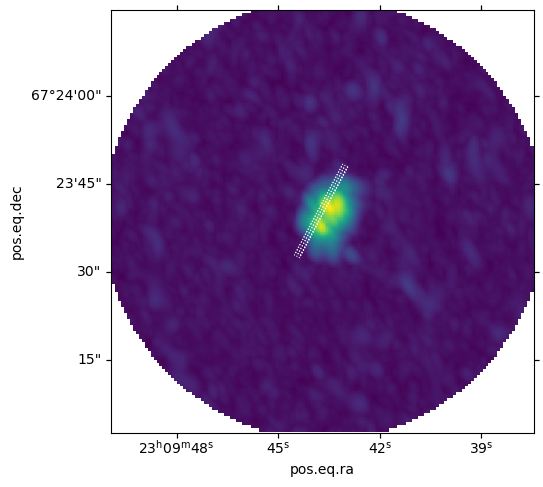

In [8]:
# First, take the same vector as in the scattered light image (as this one safely constrains the position angle)
ra_cen = 347.4323*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path2 = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=152*u.deg, sample=2, width=1.*u.arcsec)


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection=spectral_cube.wcs.celestial)
ax.imshow(spectral_cube.max(axis=0).value)
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)

/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


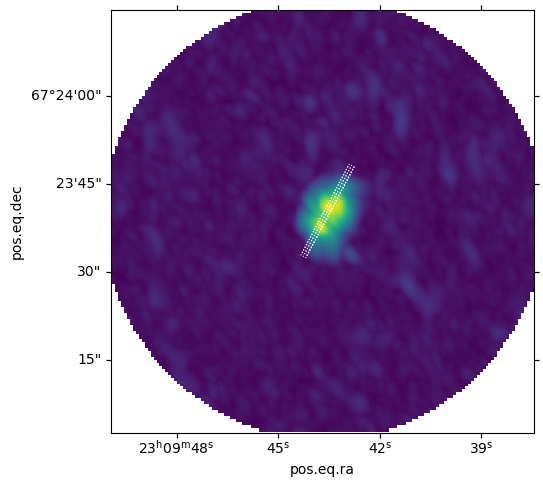

In [10]:
### Now adjust the right ascension such that it aligns with the "major axis" of the 12CO emission

# First, take the same vector as in the scattered light image (as this one safely constrains the position angle)
ra_cen = 347.4315*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path2 = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=152*u.deg, sample=2, width=1.*u.arcsec)


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection=spectral_cube.wcs.celestial)
ax.imshow(spectral_cube.max(axis=0).value)
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)

In [11]:
### Now we can compute the pv diagram:

pvdiagram2 = extract_pv_slice(cube=spectral_cube, path=Path2, spacing=1.)

/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


(23.0, 50.0)

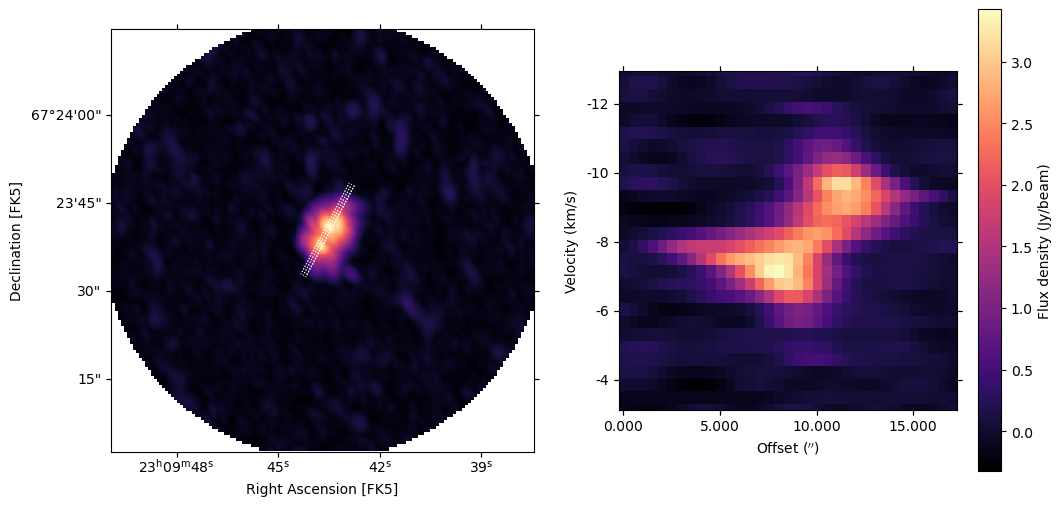

In [14]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_mom0)

ax.imshow(spectral_cube.max(axis=0).value, cmap='magma')
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)


# then show the PV diagram
ww2 = wcs.WCS(pvdiagram2.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww2)
im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)

ax.set_ylim(23, 50)

## Now overplot the Keplerian velocity profile for different disk masses

In [16]:
### First define Keplerian velocity

import astropy.constants as const
import astropy.units as u

def kepler(mass, radius, distance, inclination):
    """
    mass in solar masses
    radius in arcsec
    distance in pc
    inclination in degrees
    """
    G = const.G
    mass *= u.Msun
    physical_radius = (radius*distance)*u.au
    
    return np.sqrt(G*mass/physical_radius).to(u.km/u.s)*np.sin(inclination*u.deg)

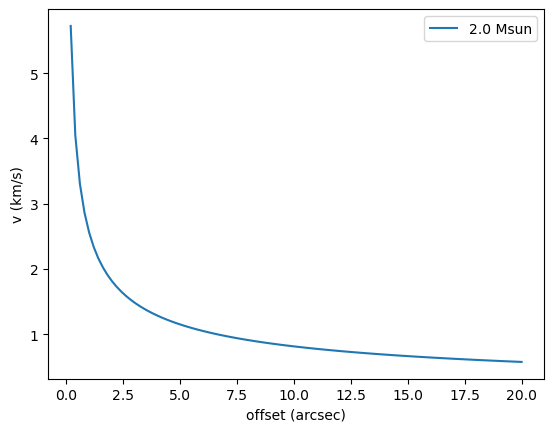

In [26]:
radii = np.linspace(0,20,100) #


plt.plot(radii, kepler(mass=2.0, radius=radii, distance=260., inclination=80.), label='2.0 Msun')

plt.xlabel('offset (arcsec)')
plt.ylabel('v (km/s)')
#plt.yscale('log')
plt.legend()
#plt.gca().invert_yaxis()


/Users/kristina/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


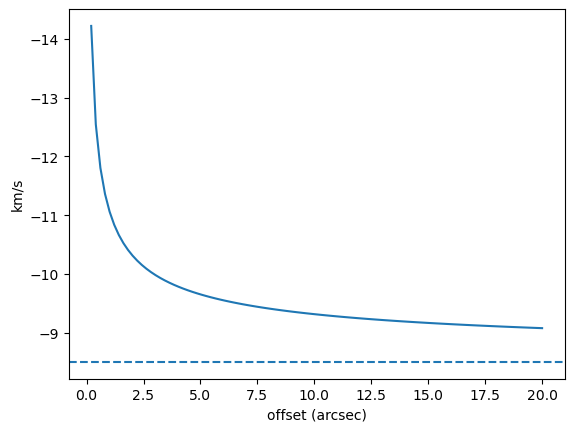

In [27]:
### Keep in mind that DraChi has a systemic velocity of -8.5 km/s, thus we need to shift v along the y-axis

radii = np.linspace(0,20,100) #

v_sys = -8.5*u.km/u.s

plt.plot(radii, v_sys-kepler(mass=2.0, radius=radii, distance=260., inclination=80.))
plt.axhline(-8.5, ls='--')

plt.xlabel('offset (arcsec)')
plt.ylabel('km/s')
#plt.yscale('log')
plt.gca().invert_yaxis()


### @ Josh: here is where I'm struggling, because ax.plot and ax.scatter only take pixel units as arguments, so I need to convert v and offset into pixel units. I've tried several ways but for some reason it's not working...

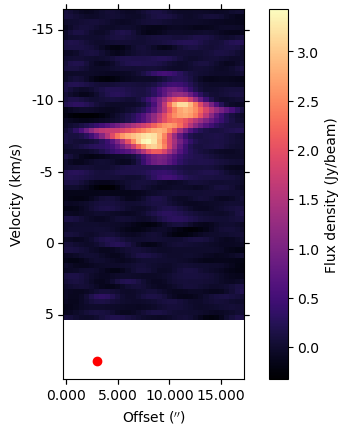

In [124]:
ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
#ax.set_aspect(1)

ax.scatter(6*u.arcsec, -8.5*u.km/u.s, transform=ax.get_transform(ww2), c='red')

#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

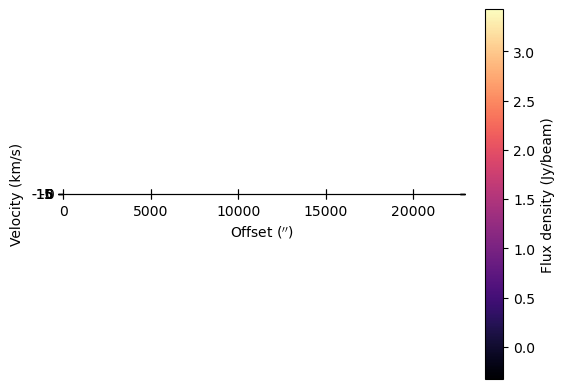

In [125]:
ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
#ax.set_aspect(1)

ax.scatter(6*u.arcsec, -8.5*u.km/u.s, transform=ax.get_transform('world'), c='red')

#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

In [111]:
from astropy.wcs import utils

pixel_scale = utils.proj_plane_pixel_scales(ww2)
pixel_scale

array([1.38888889e-04, 3.63198677e+02])

In [126]:
wcs.utils.skycoord_to_pixel(SkyCoord(ra_cen, dec_cen, frame='fk5'), wcs='fk5', origin=0, mode='all')


AttributeError: 'str' object has no attribute 'cpdis1'